In [7]:
!pip install torchtune
!pip install torchao
import torch.nn as nn
import torch
import numpy as np
import random
import math
import os
import torchtune.modules as ttm
import time
import tqdm
from sklearn.metrics import recall_score, precision_score
import json
import matplotlib.pyplot as plt

In [8]:
def seed(seed=1):
    global rank   
    global random_seed 
    random_seed = seed
    #lib seeds
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    rank = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
def create_loaders(rank, batch_size=16):
    # Load the tensors from files
    train_images = torch.load(r'/kaggle/input/image_net_10/train_images.pt', weights_only=True)
    train_labels = torch.load(r'/kaggle/input/image_net_10/train_labels.pt', weights_only=True)

    val_images = torch.load(r'/kaggle/input/image_net_10/val_images.pt', weights_only=True)
    val_labels = torch.load(r'/kaggle/input/image_net_10/val_labels.pt', weights_only=True)

    test_images = torch.load(r'/kaggle/input/image_net_10/test_images.pt', weights_only=True)
    test_labels = torch.load(r'/kaggle/input/image_net_10/test_labels.pt', weights_only=True)

    train_dataset = torch.utils.data.TensorDataset(train_images.float(), train_labels.long())
    val_dataset = torch.utils.data.TensorDataset(val_images.float(), val_labels.long())
    test_dataset = torch.utils.data.TensorDataset(test_images.float(), test_labels.long())



    def collate_gpu(batch):
        return (ele.to(rank) for ele in torch.utils.data.default_collate(batch))
    
    num_workers = 0
    persistent_workers = False
    #dataloaders 
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, persistent_workers=persistent_workers, shuffle=True, collate_fn=collate_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, persistent_workers=persistent_workers, collate_fn=collate_gpu)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, persistent_workers=persistent_workers, collate_fn=collate_gpu)

    return train_loader, val_loader, test_loader

In [10]:
from copy import deepcopy
class EarlyStoppingLoss():
    def __init__(self, patience):
        self._patience = patience
        self.current_patience = 0
        self.min_loss = float('inf')
        self.val_accuracy = None
        self.min_state_dict = None
        self.train_loss = None
        self.train_accuracy = None
        self.epoch = 0
        self.kept_epoch = None

    def stopper(self, current_model, train_loss, val_loss, train_accuracy=None, val_accuracy=None, val_f1=None, val_recall=None, val_precision=None):
        self.epoch += 1
        if val_loss < self.min_loss:
            self.train_loss = train_loss
            self.min_loss = val_loss
            
            self.train_accuracy = train_accuracy
            self.val_accuracy = val_accuracy

            self.val_recall = val_recall
            self.val_precision = val_precision

            self.val_f1 = val_f1 

            self.current_patience = 0
            self.min_state_dict = deepcopy({key: value.cpu() for key, value in current_model.state_dict().items()})
            self.kept_epoch = self.epoch
            
        else:
            self.current_patience += 1
        
        if self.current_patience >= self._patience:
            return True
        else:
            return False
        
    def get_state_dict(self):
        return self.min_state_dict  
    
    def get_current_patience(self):
        return self.current_patience
    
    def get_min_loss(self):
        return self.min_loss
    
    def get_kept_epoch(self):
        return self.kept_epoch
    
    def get_final_stats(self):
        if self.val_f1 != None:
            return self.kept_epoch, self.train_loss, self.min_loss, self.train_accuracy, self.val_accuracy, self.val_f1
        elif self.val_recall != None and self.val_precision != None:
            return self.kept_epoch, self.train_loss, self.min_loss, self.train_accuracy, self.val_accuracy, self.val_recall, self.val_precision
        else:
            self.kept_epoch, self.train_loss, self.min_loss, self.train_accuracy, self.val_accuracy,

In [11]:
def train(model, train_loader, val_loader, loss_func, optimizer, early_stopper, lr_scheduler, num_epochs, use_progress_bar=True, epoch_checkpoints_path=None):
    #list to track metrics
    train_loss_lst = []
    val_loss_lst = []
    train_accuracy_lst = []
    val_accuracy_lst = []
    val_recall_lst = []
    val_precision_lst = []
   
    #logging lst 
    logging_str = ''
        
    #timing training 
    start_total_time = time.time()
    
    #training loop
    epoch = 0
    for _ in range(num_epochs):
        ##TRAINING##
        model.train()

        #init running vars 
        train_running_loss = 0 
        #init accuracy vars
        train_correct_preds = 0

        #epoch start time 
        start_epoch_time = time.time()

        for step, (images, labels) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader), mininterval=30, disable=not use_progress_bar):
            #clear grad
            optimizer.zero_grad()

            # Get model predictions
            train_preds = model(images)
  
            # Calculate loss
            train_batch_loss = loss_func(train_preds, labels)
            
            #incrmenting running loss 
            train_running_loss += train_batch_loss.item()
            
            #grad and backprop
            train_batch_loss.backward()
            optimizer.step()
            
            if isinstance(loss_func, nn.CrossEntropyLoss):
                #calculating accuracy 
                train_correct_preds += (torch.argmax(train_preds, dim=-1) == labels).sum().item()
            else:
                #calculating accuracy 
                train_correct_preds += (torch.round(torch.sigmoid(train_preds)) == labels).sum().item()

        #dividing the loss and correct preds by total samples to yield average 
        train_loss = train_running_loss / len(train_loader)
        #calaculting the accuracy for this epoch 
        train_accuracy = train_correct_preds / len(train_loader.dataset)

        ##VALIDATION##
        model.eval()
        #init running vars
        val_running_loss = 0
        #init accuracy vars
        val_correct_preds = 0

        #f1 vars 
        cat_preds = np.array([], dtype=np.int8)
        cat_labels = np.array([], dtype=np.int8)

        with torch.no_grad():
            for images, labels in val_loader:
                
                #getting batch preds
                val_preds = model(images)

                #getting loss 
                val_batch_loss = loss_func(val_preds, labels)
                    
                #incrmenting running loss 
                val_running_loss += val_batch_loss.item()

                if isinstance(loss_func, nn.CrossEntropyLoss):
                    val_cls_preds = torch.argmax(val_preds, dim=-1)
                    #calculating accuracy 
                    val_correct_preds += (val_cls_preds == labels).sum().item()
                    #filling f1 arrays 
                    cat_preds = np.concatenate((cat_preds, val_cls_preds.cpu().numpy().astype(np.int8)))
                    cat_labels = np.concatenate((cat_labels, labels.view(-1).cpu().numpy().astype(np.int8)))
                
                else:
                    val_cls_preds = torch.round(torch.sigmoid(val_preds))
                    #calculating accuracy 
                    val_correct_preds += (val_cls_preds == labels).sum().item()
                    #filling f1 arrays 
                    cat_preds = np.concatenate((cat_preds, val_cls_preds.cpu().numpy().astype(np.int8)))
                    cat_labels = np.concatenate((cat_labels, labels.view(-1).cpu().numpy().astype(np.int8)))

            #dividing the loss and correct preds by total samples to yield average 
            val_loss = val_running_loss / len(val_loader)
            #calaculting the accuracy for this epoch 
            val_accuracy = val_correct_preds / len(val_loader.dataset) 
            #val f1 
            val_recall = recall_score(cat_labels, cat_preds, average='macro')
            val_precision = precision_score(cat_labels, cat_preds, average='macro')

            #lr scheduler step 
            lr_scheduler.step(val_loss)

        #getting end of epoch time 
        end_epoch_time = time.time()
        
        #printing all the status from the epoch 
        epoch += 1
        print(f'\nEpoch {epoch}')
        print(f'Train:      Loss = {train_loss:.16f}, Accuracy = {train_accuracy:.16f}')
        logging_str += f'Epoch {epoch}\nTrain:      Loss = {train_loss:.16f}, Accuracy = {train_accuracy:.16f}\n'
        print(f'Validation: Loss = {val_loss:.16f}, Accuracy = {val_accuracy:.16f}, Recall = {val_recall:.16f}, Precision = {val_precision:.16f}')
        print(f'Epoch Time: {round(end_epoch_time - start_epoch_time)} Seconds')
        logging_str += f'Validation: Loss = {val_loss:.16f}, Accuracy = {val_accuracy:.16f}, Recall = {val_recall:.16f}, Precision = {val_precision:.16f}\nEpoch Time: {round(end_epoch_time - start_epoch_time)} Seconds\n'
        
        #updating training lists 
        train_loss_lst.append(train_loss)
        val_loss_lst.append(val_loss)
        train_accuracy_lst.append(train_accuracy)
        val_accuracy_lst.append(val_accuracy)
        val_recall_lst.append(val_recall)
        val_precision_lst.append(val_precision)
    
        if epoch_checkpoints_path is not None:
            torch.save(model.state_dict(), epoch_checkpoints_path + f'_epoch_{epoch}_checkpoint.pth')

        #earlier stopper condition check to see if the pacients of the model has run out 
        #if it has revert model to highest f1 
        if early_stopper.stopper(model, train_loss, val_loss, train_accuracy=train_accuracy, val_accuracy=val_accuracy, val_recall=val_recall, val_precision=val_precision):
            kept_epoch, final_train_loss, final_val_loss, final_train_accuracy, final_val_accuracy, final_val_recall, final_val_precision = early_stopper.get_final_stats()
            print(f'Current Patience: {early_stopper.get_current_patience()}')
            print()
            print('Early Stopper Triggered')
            print(f'Kept Epoch: {kept_epoch}\nTrain Loss = {final_train_loss:.16f}, Accuracy = {final_train_accuracy:.16f}\nVal   Loss = {final_val_loss:.16f}, Accuracy = {final_val_accuracy:.16f}, Recall = {final_val_recall:.16f}, Precision = {final_val_precision:.16f}')
            logging_str += f'Current Patience: {early_stopper.get_current_patience()}\n\nEarly Stopper Triggered\nKept Epoch: {kept_epoch}\nTrain Loss {final_train_loss:.16f}, Accuracy = {final_train_accuracy:.16f}  \nVal   Loss = {final_val_loss:.16f}, Accuracy = {final_val_accuracy:.16f}, Recall = {final_val_recall:.16f}, Precision = {final_val_precision:.16f}\n'
            break
        else:
            print(f'Current Patience: {early_stopper.get_current_patience()}')
            print()
            logging_str += f'Current Patience: {early_stopper.get_current_patience()}\n\n'
            #loading optimal model
            state_dict = early_stopper.get_state_dict()
            model.load_state_dict(state_dict)


    #loading optimal model using early stopper after training 
    state_dict = early_stopper.get_state_dict()
    model.load_state_dict(state_dict)

    #total train time end 
    end_total_time = time.time()
    total_train_time = round(end_total_time - start_total_time)
    #printing final_stats and train time 
    print(f'Total Training Time: {total_train_time} Seconds')
    logging_str += f'Total Training Time {total_train_time} Seconds'

    #getting history of training 
    history_dict = {'train_loss_lst': train_loss_lst, 'val_loss_lst': val_loss_lst, 'train_accuracy_lst': train_accuracy_lst, 
                    'val_accuracy_lst': val_accuracy_lst, 'val_recall_lst': val_recall_lst, 'val_precision_lst': val_precision_lst}
    
    #controling for if early stopper does not finish
    if 'kept_epoch' not in locals():
        kept_epoch, final_train_loss, final_val_loss, final_train_accuracy, final_val_accuracy, final_val_recall, final_val_precision = early_stopper.get_final_stats()
        
    #getting stats of final model 
    final_stats_dict = {'kept_epoch': kept_epoch, 'train_loss': final_train_loss, 'val_loss': final_val_loss, 'train_accuracy': final_train_accuracy, 
                        'val_accuracy': final_val_accuracy, 'val_recall': final_val_recall, 'val_precision': final_val_precision, 'total_train_time': total_train_time}
    
    return model, history_dict, final_stats_dict, logging_str

def test(model, test_loader, loss_func):
    start_time = time.time()
    
    model.eval()
    ##TEST##
    #init running vars
    test_running_loss = 0
    #init accuracy vars
    test_correct_preds = 0

    #f1 vars 
    cat_preds = np.array([], dtype=np.int8)
    cat_labels = np.array([], dtype=np.int8)
    
    with torch.no_grad():
        for images, labels in test_loader:

            #getting batch preds
            test_preds = model(images)

            #getting loss 
            test_batch_loss = loss_func(test_preds, labels)

            #incrmenting running loss 
            test_running_loss += test_batch_loss.item() 

            if isinstance(loss_func, nn.CrossEntropyLoss):
                test_cls_preds = torch.argmax(test_preds, dim=-1)
                #calculating accuracy 
                test_correct_preds += (test_cls_preds == labels).sum().item()
                #filling f1 arrays 
                cat_preds = np.concatenate((cat_preds, test_cls_preds.cpu().numpy().astype(np.int8)))
                cat_labels = np.concatenate((cat_labels, labels.view(-1).cpu().numpy().astype(np.int8)))
            else:
                test_cls_preds = torch.round(torch.sigmoid(test_preds))
                #calculating accuracy 
                test_correct_preds += (test_cls_preds == labels).sum().item()
                #filling f1 arrays 
                cat_preds = np.concatenate((cat_preds, test_cls_preds.cpu().numpy().astype(np.int8)))
                cat_labels = np.concatenate((cat_labels, labels.view(-1).cpu().numpy().astype(np.int8)))               
 
        #dividing the loss and correct preds by total samples to yield average 
        test_loss = test_running_loss / len(test_loader)
        #calaculting the accuracy for this epoch 
        test_accuracy = test_correct_preds / len(test_loader.dataset)
        #test f1 
        test_recall = recall_score(cat_labels, cat_preds, average='macro')
        test_precision = precision_score(cat_labels, cat_preds, average='macro')

        stop_time = time.time()
        inference_time = stop_time - start_time
        
        #printing to consel
        print()
        print(f'Test: Loss = {test_loss:.16f}, Accuracy = {test_accuracy:.16f}, Recall = {test_recall:.16f}, Precision = {test_precision:.16f}')
        print(f'Total Inference Time: {inference_time} Seconds')

    return {'test_loss': test_loss, 'test_accuracy': test_accuracy, 'test_recall': test_recall, 'test_precision': test_precision}

def plot(history_dict, final_stats_dict, test_dict):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24,6))

    epochs = np.arange(len(history_dict['train_loss_lst'])) + 1
    kept_epoch = final_stats_dict['kept_epoch']

    #ploting loss 
    ax1.plot(epochs, history_dict['train_loss_lst'], label='Train Loss')
    ax1.plot(epochs, history_dict['val_loss_lst'], label='Val Loss')
    ax1.axhline(test_dict['test_loss'], color='r', linestyle='--', label='Test Loss')
    ax1.axvline(kept_epoch, color='g', linestyle='--', label='Kept Epoch')
    ax1.text(0.5, -0.2, f"Kept Epoch: {final_stats_dict['kept_epoch']}\n Train Loss: {final_stats_dict['train_loss']:.4f}, Val Loss: {final_stats_dict['val_loss']:.4f}, Test Loss: {test_dict['test_loss']:.4f}", ha='center', va='center', transform=ax1.transAxes)
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 2))    
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Loss Over Epochs')

    #train vs val accuracy 
    ax2.plot(epochs, history_dict['train_accuracy_lst'], label="Train Accuracy Over Epochs")
    ax2.plot(epochs, history_dict['val_accuracy_lst'], label='Val Accuracy Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim(0, 1.1)
    ax2.axvline(x=kept_epoch, color='green', linestyle='--', label="Saved Epoch")
    ax2.axhline(y=test_dict['test_accuracy'], color='r', linestyle='--', label='Test Accuracy')
    ax2.text(0.5, -0.2, f"Kept Epoch: {final_stats_dict['kept_epoch']}\n Train Accuracy: {final_stats_dict['train_accuracy']:.4f}, Val Accuracy: {final_stats_dict['val_accuracy']:.4f}, Test Accuracy: {test_dict['test_accuracy']:.4f}", ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Accuracy Over Epochs')
    ax2.legend()

    #recall
    ax3.plot(epochs, history_dict['val_recall_lst'], label='Val Recall Score', color='orange')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Recall Score')
    ax3.set_ylim(0, 1.1)
    ax3.axvline(x=kept_epoch, color='green', linestyle='--', label="Saved Epoch")
    ax3.axhline(y=test_dict['test_recall'], color='r', linestyle='--', label='Test Recall')
    ax3.text(0.5, -0.2, f"Kept Epoch: {final_stats_dict['kept_epoch']}\n Val Recall: {final_stats_dict['val_recall']:.4f}, Test Recall: {test_dict['test_recall']:.4f}", ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Recall Over Epochs')
    ax3.legend()

    #precision
    ax4.plot(epochs, history_dict['val_precision_lst'], label='Val Precision Score', color='orange')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Precision Score')
    ax4.set_ylim(0, 1.1)
    ax4.axvline(x=kept_epoch, color='green', linestyle='--', label="Saved Epoch")
    ax4.axhline(y=test_dict['test_precision'], color='r', linestyle='--', label='Test Precision')
    ax4.text(0.5, -0.2, f"Kept Epoch: {final_stats_dict['kept_epoch']}\n Val Precision: {final_stats_dict['val_precision']:.4f}, Test Precision: {test_dict['test_precision']:.4f}", ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Precision Over Epochs')
    ax4.legend()

    fig.text(.5, .92, f"Total Train Time {(final_stats_dict['total_train_time'] / 60):.0f} Minutes", ha='center')
    fig.suptitle(f'Loss and Accuracy Over Epochs')

    return fig 

def save_model(path, fig, config, model, logging_str):
    #saving stuff
    fig.savefig(path + rf'.png', bbox_inches='tight')
    with open(path + rf'_config.json', 'w') as file:
        json.dump(config, file)

    with open(path + rf'_logging.txt', 'w') as file:
        file.write(logging_str)

    state_dict = model.state_dict()
    torch.save(state_dict, path + rf'.pth')

Number of parameters:  85806346



100%|██████████| 293/293 [02:57<00:00,  1.65it/s]



Epoch 1
Train:      Loss = 1.9853586113086739, Accuracy = 0.3049600000000000
Validation: Loss = 1.6393332840904358, Accuracy = 0.4221005475360876, Recall = 0.4202438745758087, Precision = 0.4929837868840384
Epoch Time: 190 Seconds
Current Patience: 0



100%|██████████| 293/293 [02:57<00:00,  1.65it/s]



Epoch 2
Train:      Loss = 1.4868222389611774, Accuracy = 0.4875733333333334
Validation: Loss = 1.3688678400857108, Accuracy = 0.5236436037829766, Recall = 0.5217540226929097, Precision = 0.5613577128988131
Epoch Time: 189 Seconds
Current Patience: 0



100%|██████████| 293/293 [02:57<00:00,  1.65it/s]



Epoch 3
Train:      Loss = 1.2506205085601416, Accuracy = 0.5780266666666667
Validation: Loss = 1.3544659453725059, Accuracy = 0.5400696864111498, Recall = 0.5401583725454551, Precision = 0.6032886012280928
Epoch Time: 189 Seconds
Current Patience: 0



100%|██████████| 293/293 [02:57<00:00,  1.65it/s]



Epoch 4
Train:      Loss = 1.1259651597042539, Accuracy = 0.6236800000000000
Validation: Loss = 1.1733654008971319, Accuracy = 0.6047784967645595, Recall = 0.6044231560217743, Precision = 0.6198467070903604
Epoch Time: 189 Seconds
Current Patience: 0



100%|██████████| 293/293 [02:57<00:00,  1.65it/s]



Epoch 5
Train:      Loss = 1.0148952655214498, Accuracy = 0.6550400000000000
Validation: Loss = 1.1728263885255843, Accuracy = 0.6017919362867098, Recall = 0.5993701847727515, Precision = 0.6176175517973583
Epoch Time: 189 Seconds
Current Patience: 0



100%|██████████| 293/293 [02:57<00:00,  1.65it/s]



Epoch 6
Train:      Loss = 0.8767335573560956, Accuracy = 0.7090133333333334
Validation: Loss = 1.1960763363611131, Accuracy = 0.6087605774016924, Recall = 0.6075235109717868, Precision = 0.6298792452139634
Epoch Time: 189 Seconds
Current Patience: 1



100%|██████████| 293/293 [02:57<00:00,  1.65it/s]



Epoch 7
Train:      Loss = 0.8795303115462281, Accuracy = 0.7058133333333333
Validation: Loss = 1.1625662379794650, Accuracy = 0.6067695370831260, Recall = 0.6068387800820070, Precision = 0.6287936263500914
Epoch Time: 189 Seconds
Current Patience: 0



100%|██████████| 293/293 [02:57<00:00,  1.65it/s]



Epoch 8
Train:      Loss = 0.7973917069695509, Accuracy = 0.7290666666666666
Validation: Loss = 1.1364655523073106, Accuracy = 0.6241911398705824, Recall = 0.6229334509805661, Precision = 0.6340429349807959
Epoch Time: 189 Seconds
Current Patience: 0



100%|██████████| 293/293 [02:57<00:00,  1.65it/s]



Epoch 9
Train:      Loss = 0.7290102697069735, Accuracy = 0.7548800000000000
Validation: Loss = 1.1013129239990598, Accuracy = 0.6361373817819811, Recall = 0.6348470329501799, Precision = 0.6486143708990003
Epoch Time: 189 Seconds
Current Patience: 0



100%|██████████| 293/293 [02:57<00:00,  1.65it/s]



Epoch 10
Train:      Loss = 0.6182078577247496, Accuracy = 0.7904000000000000
Validation: Loss = 1.2194067041079204, Accuracy = 0.6331508213041314, Recall = 0.6312751544641571, Precision = 0.6359965656353532
Epoch Time: 189 Seconds
Current Patience: 1



100%|██████████| 293/293 [02:57<00:00,  1.65it/s]



Epoch 11
Train:      Loss = 0.6189877374078634, Accuracy = 0.7897600000000000
Validation: Loss = 1.2754293055761428, Accuracy = 0.6037829766052762, Recall = 0.6043227272596863, Precision = 0.6527179051496271
Epoch Time: 189 Seconds
Current Patience: 2



100%|██████████| 293/293 [02:57<00:00,  1.65it/s]



Epoch 12
Train:      Loss = 0.5938921283434683, Accuracy = 0.8006400000000000
Validation: Loss = 1.2727372272620125, Accuracy = 0.6092583374813340, Recall = 0.6081345601960949, Precision = 0.6442659175880456
Epoch Time: 189 Seconds
Current Patience: 3



100%|██████████| 293/293 [02:57<00:00,  1.65it/s]



Epoch 13
Train:      Loss = 0.4046563965112683, Accuracy = 0.8711466666666666
Validation: Loss = 1.2090851513166276, Accuracy = 0.6660029865604778, Recall = 0.6650975688701874, Precision = 0.6701779856043860
Epoch Time: 189 Seconds
Current Patience: 4



100%|██████████| 293/293 [02:57<00:00,  1.65it/s]



Epoch 14
Train:      Loss = 0.3972526725648613, Accuracy = 0.8726400000000000
Validation: Loss = 1.1844229641414823, Accuracy = 0.6674962667994027, Recall = 0.6665032976783625, Precision = 0.6698260997163213
Epoch Time: 189 Seconds
Current Patience: 5

Early Stopper Triggered
Kept Epoch: 9
Train Loss = 0.7290102697069735, Accuracy = 0.7548800000000000
Val   Loss = 1.1013129239990598, Accuracy = 0.6361373817819811, Recall = 0.6348470329501799, Precision = 0.6486143708990003
Total Training Time: 2652 Seconds

Test: Loss = 1.2061929920363048, Accuracy = 0.6029850746268657, Recall = 0.6011238344929828, Precision = 0.6142309626495805
Total Inference Time: 11.827118635177612 Seconds


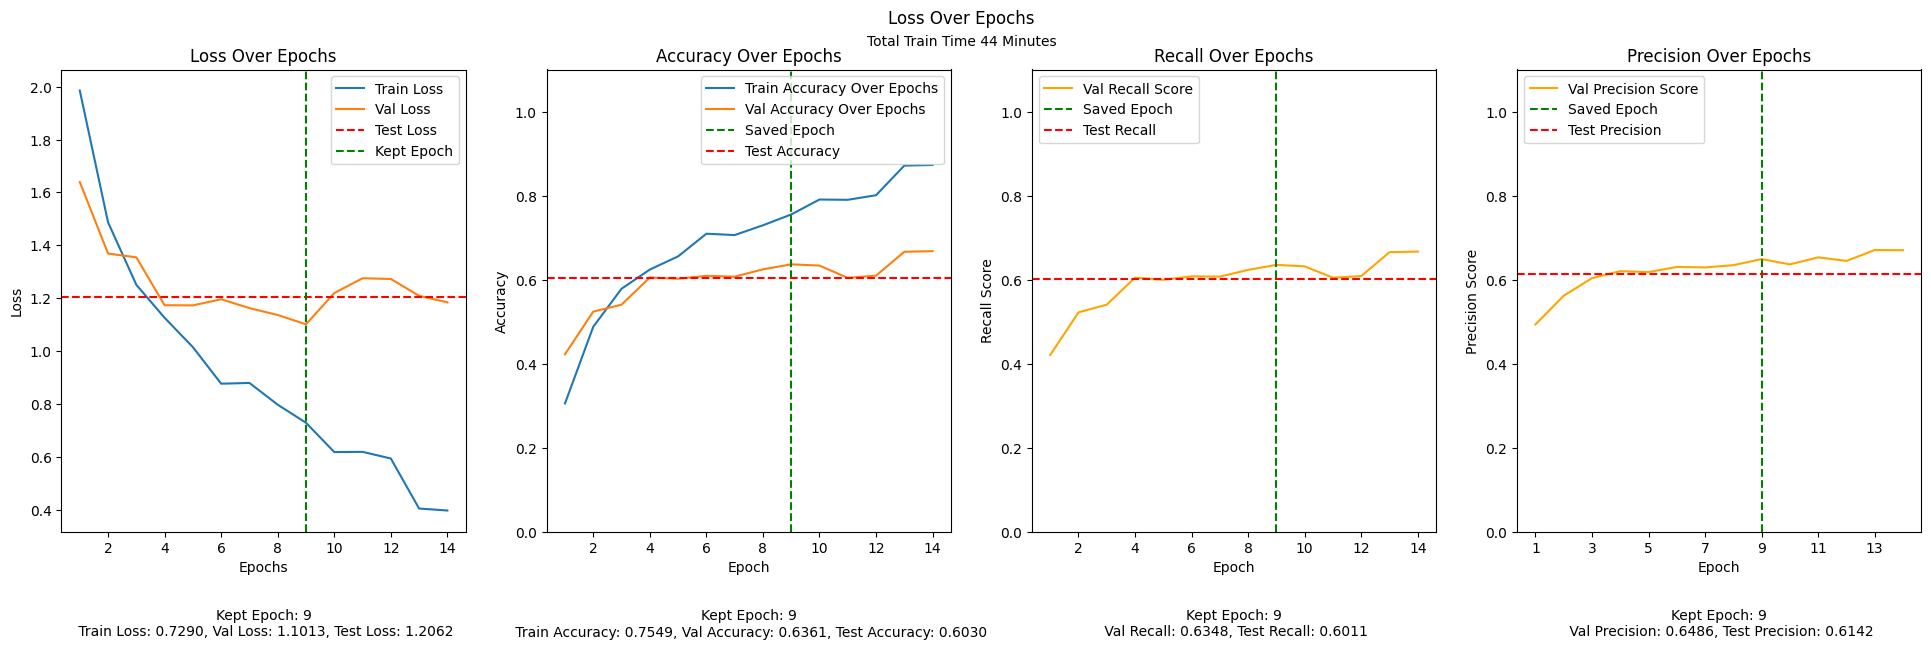

In [12]:
import torchvision as tv
def run_job():
    seed()
    train_loader, val_loader, test_loader = create_loaders(rank, batch_size=32)
    #model hyperparas 
    #num classes for mlp head 
    num_classes = 10

    #training hyperparas 
    #num epochs to train
    num_epochs = 1000
    #patience
    patience = 5
    #max lr 
    lr = 1e-4
    #saving the model, config, logging, and figure
    saving_path = rf'/kaggle/working/base_model_premade'

    model = tv.models.vit_b_16(weights=None).to(rank)
    in_features = model.heads.head.in_features
    model.heads.head = torch.nn.Linear(in_features, num_classes).to(rank)
   
    #loss function
    loss_func = nn.CrossEntropyLoss()

    #optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    #lr scheduler 
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
    #init early stopper 
    early_stopper = EarlyStoppingLoss(patience)

    total_params = sum(para.numel() for para in model.parameters())
    print("Number of parameters: ", total_params)
    print()
    # print("The number of parameters each part of the transfromer model")
    # for name, param in model.named_parameters():
    #     print(f"Layer: {name}, Parameters: {param.numel()}")

    config = {'num_classes': num_classes, 'num_epochs': num_epochs, 'patience': patience, 'lr': lr, 'total_parameters': total_params}
    
    #model training and testing
    model, history, final_stats_dict, logging_str = train(model, train_loader, val_loader, 
                                                          loss_func, optimizer, early_stopper, 
                                                          scheduler, num_epochs)
    #run test partition 
    test_dict = test(model, test_loader, loss_func)

    #plot figure
    fig = plot(history, final_stats_dict, test_dict)
    fig.suptitle(f'Loss Over Epochs')

    save_model(saving_path, fig, config, model, logging_str)
    
run_job()